In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree


from synthesize import SyntheticDataset

## Creating a Mouse Brain Cortex Dataset Generator

In [2]:
def cartesian_to_polar(x, y, origin=(0.5, 0.5)):
    x_0, y_0 = origin
    centered_x = x - x_0
    centered_y = y - y_0
    r = np.sqrt(centered_x**2 + centered_y**2)
    theta = np.arctan2(centered_y, centered_x)
    
    theta[theta < 0] = 2 * np.pi - theta[theta < 0]

    return (r, theta)

def polar_to_cartesian(r, theta, origin=(0.5, 0.5)):
    x_0, y_0 = origin
    centered_x = r * np.cos(theta)
    centered_y = r * np.sin(theta)

    return (centered_x + x_0, centered_y + y_0)

def archimedean_spiral(theta, a=0, b=1):
    return a + b * theta
    
def first_spiral(theta):
    return archimedean_spiral(theta, b=23)

def second_spiral(theta):
    return archimedean_spiral(theta, a=np.pi/2, b=22)

def third_spiral(theta):
    return archimedean_spiral(theta, a=np.pi, b=21)

def fourth_spiral(theta):
    return archimedean_spiral(theta, a=3/2 *np.pi, b=20)

def in_layer(coordinates, layer, theta_range=100, theta_step=0.005):
    theta_samples = np.arange(0, theta_range, theta_step)
    
    first_spiral_samples = first_spiral(theta_samples)
    second_spiral_samples = second_spiral(theta_samples)
    third_spiral_samples = third_spiral(theta_samples)
    fourth_spiral_samples = fourth_spiral(theta_samples)
    
    spiral_samples = np.hstack([first_spiral_samples, second_spiral_samples, third_spiral_samples, fourth_spiral_samples])
    spiral_coordinates = np.vstack([np.tile(theta_samples, 4), spiral_samples])
    spiral_euclidean_coordinates = polar_to_cartesian(*spiral_coordinates)
    
    voronoi = Voronoi(np.vstack([*spiral_euclidean_coordinates]).T)
    voronoi_kdtree = cKDTree(np.vstack([*spiral_euclidean_coordinates]).T)
    _, test_point_regions = voronoi_kdtree.query(coordinates)
    
    return (len(theta_samples) * layer <= test_point_regions) & (test_point_regions <= len(theta_samples) * (layer+1))

In [12]:
theta_samples = np.arange(0, 100, 0.005)
x, y = np.meshgrid(np.arange(0, 1, 0.02), np.arange(0, 1, 0.02))
coordinates = np.vstack([x.ravel(), y.ravel()]).T
first_spiral_samples = first_spiral(theta_samples)
second_spiral_samples = second_spiral(theta_samples)
third_spiral_samples = third_spiral(theta_samples)
fourth_spiral_samples = fourth_spiral(theta_samples)
spiral_samples = np.hstack([first_spiral_samples, second_spiral_samples, third_spiral_samples, fourth_spiral_samples])
spiral_coordinates = np.vstack([np.tile(theta_samples, 4), spiral_samples])
spiral_euclidean_coordinates = polar_to_cartesian(*spiral_coordinates)
voronoi = Voronoi(np.vstack([*spiral_euclidean_coordinates]).T)

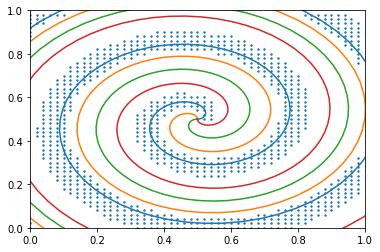

In [13]:
voronoi_kdtree = cKDTree(np.vstack([*spiral_euclidean_coordinates]).T)
_, test_point_regions = voronoi_kdtree.query(coordinates)
plt.plot(*polar_to_cartesian(theta_samples, first_spiral(theta_samples)))
plt.plot(*polar_to_cartesian(theta_samples, second_spiral(theta_samples)))
plt.plot(*polar_to_cartesian(theta_samples, third_spiral(theta_samples)))
plt.plot(*polar_to_cartesian(theta_samples, fourth_spiral(theta_samples)))
plt.scatter(*coordinates[test_point_regions < len(theta_samples)].T, s=2)
# plt.scatter()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [14]:
class SyntheticMouseBrainCortexSpiralDataset(SyntheticDataset):
    """Synthetic mouse brain cortex dataset with ciruclar pattterns.
    
    This class provides methods for initializing a semi-random mouse cortex spatial
    transcriptomics dataset, as well as methods to visualize aspects of the dataset.
    
    Data consists of 4 layers of widths [.35, .15, .25, .25]. Each layer has a
    unique excitatory neuronal type. There are three inhibitory neuronal
    types which have slight layer preferences. There are two layer-specific
    non-neuron types, one of which constitutes most of layer 2. There is a
    third non-neuron type, which is uniformly distributed throughout.
    0 - Excitatory L1
    1 - Excitatory L2
    2 - Excitatory L3
    3 - Excitatory L4
    4 - Inhibitory 1
    5 - Inhibitory 2
    6 - non-Neuron L1
    7 - non-Neuron (ubiquitous)

    Metagenes
    0 - Excitatory
    1 - In
    2 - Inhibitory-1
    3 - Inhibitory-2
    4 - non-Neuron 1
    5 - non-Neuron 2
    6 - L1
    7 - L2
    8 - L3
    9 - L4
    10 - end - random
    """
    
    distributions = np.array([
        [0.33, 0, 0, 0, 0.1, 0, 0.5, 0.07],
        [0, 0.93, 0, 0, 0, 0, 0, 0.07],
        [0, 0, 0.53, 0, 0.1, 0.3, 0, 0.07],
        [0, 0, 0, 0.73, 0.1, 0.1, 0, 0.07]
    ])
    
    cell_type_definitions = np.array([
        [   # Layer 1
            [1, 0, 0, 0, 0, 0, 0.6, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0.6, 0, 0, 0, 0.3, 0, 0, 0], # Inhibitory 1
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0.3, 0, 0, 0], # Non-Neuron 2
            [0, 0, 0, 0, 1, 0, 0.3, 0, 0, 0] 
        ],
        [   # Layer 2
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0.6, 0, 0], # Excitatory L2
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0.3, 0, 0]   
        ],
        [   # Layer 3
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0, 0.6, 0], # Excitatory L3
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0.6, 0, 0, 0, 0, 0, 0.3, 0], # Inhibitory 1
            [0, 1, 0, 0.6, 0, 0, 0, 0, 0.3, 0], # Inhibitory 2
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0.3, 0]   
        ],
        [   # Layer 4
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0.6], # Excitatory L4
            [0, 1, 0.6, 0, 0, 0, 0, 0, 0, 0.3], # Inhibitory 1
            [0, 1, 0, 0.6, 0, 0, 0, 0, 0, 0.3], # Inhibitory 2
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0.3]   
        ]
    ])
    
    mask_conditions = [
        (lambda coordinates: in_layer(coordinates, 0)),
        (lambda coordinates: in_layer(coordinates, 1)),
        (lambda coordinates: in_layer(coordinates, 2)),
        (lambda coordinates: in_layer(coordinates, 3))
    ]
    
    metagene_variation_probabilities = [0, 0.25, 0, 0.25, 0, 0.25, 0, 0.1, 0.1, 0.1]
    
    def __init__(self, parameters, parent_directory, shared_metagenes=None, key=''):
        super().__init__(SyntheticMouseBrainCortexCircularDataset.distributions,
                         SyntheticMouseBrainCortexCircularDataset.cell_type_definitions,
                         SyntheticMouseBrainCortexCircularDataset.mask_conditions,
                         SyntheticMouseBrainCortexCircularDataset.metagene_variation_probabilities,
                         parameters, parent_directory, shared_metagenes=None, key='')
        

## Generating Datasets

In [7]:
# Create Datasets
instances = 2
parent_directory = "../../data/synthetic_data_spiral"
parameters_options = [{'n_cells': 500, 'n_genes': 100, 'num_replicates': 16,
             'sigX_scale': 3.0, 'sigY_scale': 2.0,
             'real_metagene_parameter': 4.0, 'noise_metagene_parameter': 8.0, 'lambda_s': 1.0,
             'gene_replace_prob': 0.0, 'element_replace_prob': 0.0,
             "num_real_metagenes":10, 'n_noise_metagenes': 3, 'num_shared_metagenes': 5}]

datasets = []
for parameters in parameters_options:
    for instance in range(instances):
        dataset = SyntheticMouseBrainCortexCircularDataset(parameters, parent_directory)
        datasets.append(dataset)
        dataset.save_pickle()
        dataset.reformat()

Synthesizing M...
Synthesizing X, A, and p...
Synthesizing Y...
Finished
Synthesizing M...
Synthesizing X, A, and p...
Synthesizing Y...
Finished


## Plotting Datasets

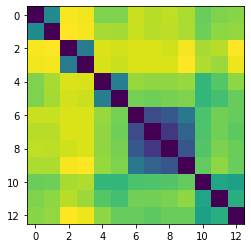

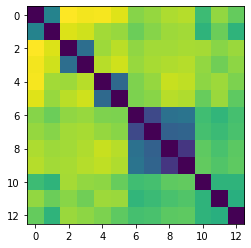

In [8]:
for instance in range(instances):
    dataset = datasets[instance]
    plt.figure()
    plt.imshow(pairwise_distances(dataset.metagenes.T))
    plt.show()
    plt.close()

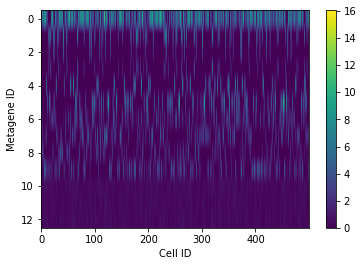

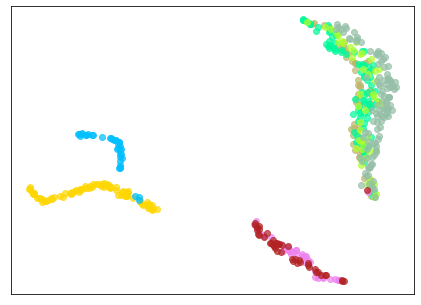

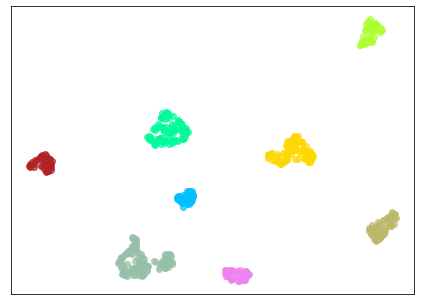

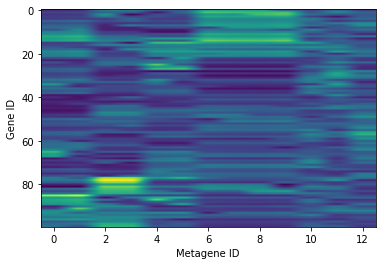

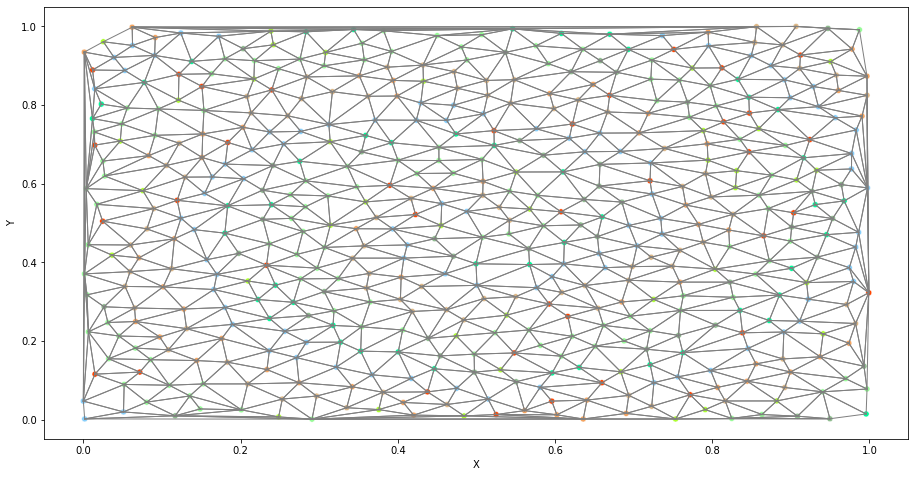

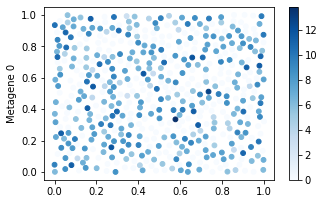

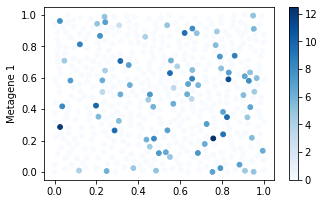

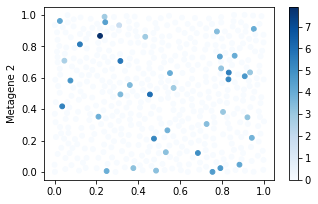

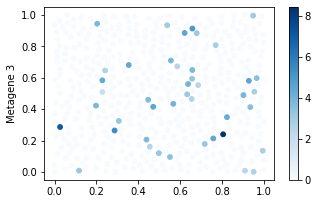

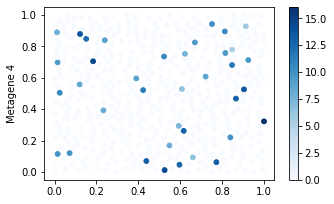

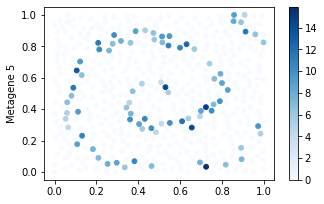

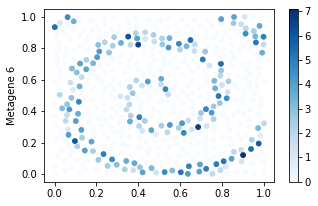

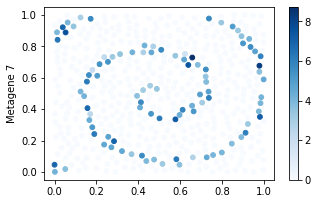

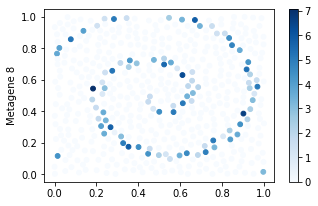

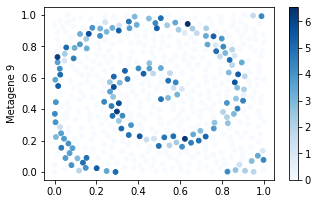

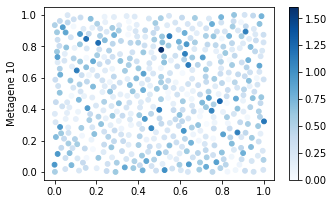

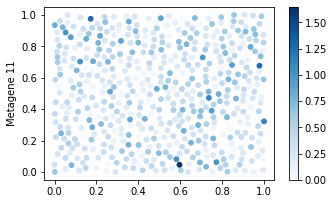

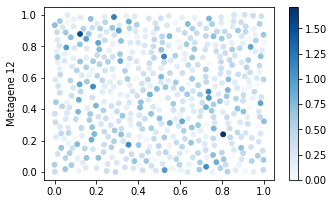

In [9]:
first_dataset = datasets[0]
first_dataset.plot_hidden_states()
first_dataset.plot_cells_UMAP(latent_space=False)
first_dataset.plot_cells_UMAP(latent_space=True)
first_dataset.plot_metagenes()
first_dataset.plot_cell_types()
first_dataset.plot_metagenes_in_situ()